In [2]:
import datetime as datetime
import datetime 
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re
import string
import unidecode
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer

stopwords = nltk.corpus.stopwords.words('english')


import sklearn as sk
import xgboost
from xgboost import XGBClassifier
import category_encoders as ce

from matplotlib import pyplot
from sklearn.utils import shuffle
from numpy import sort
from matplotlib import pyplot
from xgboost import plot_importance

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import mutual_info_classif

from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, KFold

from sklearn.metrics import accuracy_score, r2_score, classification_report, mean_squared_error, mean_absolute_error
from sklearn.linear_model import LogisticRegression

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier

from sklearn.preprocessing import StandardScaler
from lightgbm.sklearn import LGBMClassifier

[nltk_data] Downloading package stopwords to /home/martin/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
train = pd.read_csv('../../train.csv', low_memory=False)
test = pd.read_csv('../../test.csv', low_memory=False)

In [4]:
def concatenate(x,char):
    words = ""
    for word in x:
        if word.startswith(char):
            words = words + word + " "
    return words

def count_vowels(x):
    return (x.count('a') + x.count('e') + x.count('i') + x.count('o') + x.count('u'))

def count_short_words(x):
    count = 0
    words = x.split(' ')
    for word in words:
        if 1 <= len(word) <= 3:
            count += 1
    return count

def count_stopwords(x):
    count = 0
    words = x.split(' ')
    for word in words:
        if word in stopwords:
            count += 1
    return count

In [5]:
def remove_punctuation(word):        
    clean_word = ''.join([char for char in word if char not in string.punctuation])
    return clean_word

def cleaning_text(text):
    tokenizer = TweetTokenizer(strip_handles=True, reduce_len=True)
    text_tokenize = tokenizer.tokenize(text)
    wordlist = []
    for word in text_tokenize:
        word = word.lower()
        word = re.sub('(?P<url>https?://[^\s]+)', ' ', word)
        word = remove_punctuation(word)
        word = re.sub(r'[^\w]', ' ', word)
        word = unidecode.unidecode(word)
        word = re.sub(r'[0-9]','', word)
        if((word != '')&(word != ' ')&(word not in stopwords)):
            wordlist.append(word)
    clean_text = ' '.join(wordlist)
    return clean_text

In [6]:
train["special_chars_count"] =  train["text"]
train["special_chars_count"] =  train["special_chars_count"].str.lower()
train["special_chars_count"] = train["special_chars_count"].apply(lambda x: re.sub(r'[a-z]','',x))
train["special_chars_count"] = train["special_chars_count"].str.strip()
train["special_chars_count"] = train["special_chars_count"].apply(lambda x: re.sub(' +','', x))
train["special_chars_count"] = train["special_chars_count"].apply(lambda x: re.sub(r'[0-9]','', x))
train["special_chars_count"] = train["special_chars_count"].str.len()

train["hashtags"] = train["text"].str.lower().str.split(' ').apply(lambda x: concatenate(x,'#'))
train["labels"] = train["text"].str.lower().str.split(' ').apply(lambda x: concatenate(x,'@'))
train["hashtags_count"] = train["hashtags"].str.split(' ').apply(lambda x: len(x))-1
train["labels_count"] = train["labels"].str.split(' ').apply(lambda x: len(x))-1

train["num_chars_count"] = train["text"]
train["num_chars_count"] =  train["num_chars_count"].str.lower()
train["num_chars_count"] = train["num_chars_count"].apply(lambda x: re.sub(r'[a-z]','',x))
train["num_chars_count"] = train["num_chars_count"].apply(lambda x: re.sub(r'[^\w]','',x))
train["num_chars_count"] = train["num_chars_count"].str.strip()
train["num_chars_count"] = train["num_chars_count"].str.len()

train["clean_text"] = train["text"].apply(lambda x: cleaning_text(x))

train["text"] = train["text"].str.lower()
train["text"] = train["text"].apply(lambda x: re.sub('(?P<url>https?://[^\s]+)', ' ', x))
train["text"] = train["text"].apply(lambda x: re.sub(r'[^\w]', ' ', x))
train["text"] = train["text"].apply(lambda x: re.sub(r'_', ' ', x))
train["text"] = train["text"].apply(lambda x: re.sub(r'[0-9]',' ', x))
train["text"] = train["text"].apply(lambda x: re.sub(' +',' ', x))
train["text"] = train["text"].apply(lambda x: re.sub(r'\b\w{1}\b', '', x))
train["text"] = train["text"].apply(lambda x: unidecode.unidecode(x))
train["text"] = train["text"].str.strip()
train["text_length"] = train["text"].str.len()
train["words_count"] = train["text"].str.split(' ').apply(lambda x: len(x))

train["keyword"] = train["keyword"].str.replace('%20',' ')

train["vowels_count"] = train["text"].apply(lambda x: count_vowels(x))
train["short_words_count"] = train["text"].apply(lambda x: count_short_words(x))
train["stopwords_count"] = train["text"].apply(lambda x: count_stopwords(x))


train.head()

,id,keyword,location,text,target,special_chars_count,hashtags,labels,hashtags_count,labels_count,num_chars_count,clean_text,text_length,words_count,vowels_count,short_words_count,stopwords_count
0,1,NaN,NaN,our deeds are the reason of this earthquake ma...,1,1,#earthquake,,1,0,0,deeds reason earthquake may allah forgive us,68,13,25,7,6
1,4,NaN,NaN,forest fire near la ronge sask canada,1,1,,,0,0,0,forest fire near la ronge sask canada,37,7,13,1,0
2,5,NaN,NaN,all residents asked to shelter in place are be...,1,3,,,0,0,0,residents asked shelter place notified officer...,130,22,45,9,11
3,6,NaN,NaN,people receive wildfires evacuation orders in ...,1,2,#wildfires,,1,0,5,people receive wildfires evacuation orders cal...,56,7,24,1,1
4,7,NaN,NaN,just got sent this photo from ruby alaska as s...,1,2,#alaska #wildfires,,2,0,0,got sent photo ruby alaska smoke wildfires pou...,84,16,24,2,6


In [7]:
test["special_chars_count"] =  test["text"]
test["special_chars_count"] =  test["special_chars_count"].str.lower()
test["special_chars_count"] = test["special_chars_count"].apply(lambda x: re.sub(r'[a-z]','',x))
test["special_chars_count"] = test["special_chars_count"].str.strip()
test["special_chars_count"] = test["special_chars_count"].apply(lambda x: re.sub(' +','', x))
test["special_chars_count"] = test["special_chars_count"].apply(lambda x: re.sub(r'[0-9]','', x))
test["special_chars_count"] = test["special_chars_count"].str.len()

test["hashtags"] = test["text"].str.lower().str.split(' ').apply(lambda x: concatenate(x,'#'))
test["labels"] = test["text"].str.lower().str.split(' ').apply(lambda x: concatenate(x,'@'))
test["hashtags_count"] = test["hashtags"].str.split(' ').apply(lambda x: len(x))-1
test["labels_count"] = test["labels"].str.split(' ').apply(lambda x: len(x))-1

test["num_chars_count"] = test["text"]
test["num_chars_count"] =  test["num_chars_count"].str.lower()
test["num_chars_count"] = test["num_chars_count"].apply(lambda x: re.sub(r'[a-z]','',x))
test["num_chars_count"] = test["num_chars_count"].apply(lambda x: re.sub(r'[^\w]','',x))
test["num_chars_count"] = test["num_chars_count"].str.strip()
test["num_chars_count"] = test["num_chars_count"].str.len()

test["clean_text"] = test["text"].apply(lambda x: cleaning_text(x))

test["text"] = test["text"].str.lower()
test["text"] = test["text"].apply(lambda x: re.sub('(?P<url>https?://[^\s]+)', ' ', x))
test["text"] = test["text"].apply(lambda x: re.sub(r'[^\w]', ' ', x))
test["text"] = test["text"].apply(lambda x: re.sub(r'_', ' ', x))
test["text"] = test["text"].apply(lambda x: re.sub(r'[0-9]',' ', x))
test["text"] = test["text"].apply(lambda x: re.sub(' +',' ', x))
test["text"] = test["text"].apply(lambda x: re.sub(r'\b\w{1}\b', '', x))
test["text"] = test["text"].apply(lambda x: unidecode.unidecode(x))
test["text"] = test["text"].str.strip()
test["text_length"] = test["text"].str.len()
test["words_count"] = test["text"].str.split(' ').apply(lambda x: len(x))

test["keyword"] = test["keyword"].str.replace('%20',' ')

test["vowels_count"] = test["text"].apply(lambda x: count_vowels(x))
test["short_words_count"] = test["text"].apply(lambda x: count_short_words(x))
test["stopwords_count"] = test["text"].apply(lambda x: count_stopwords(x))


test.head()

,id,keyword,location,text,special_chars_count,hashtags,labels,hashtags_count,labels_count,num_chars_count,clean_text,text_length,words_count,vowels_count,short_words_count,stopwords_count
0,0,NaN,NaN,just happened terrible car crash,0,,,0,0,0,happened terrible car crash,33,6,9,1,1
1,2,NaN,NaN,heard about earthquake is different cities sta...,3,#earthquake,,1,0,0,heard earthquake different cities stay safe ev...,61,9,24,1,2
2,3,NaN,NaN,there is forest fire at spot pond geese are f...,2,,,0,0,0,forest fire spot pond geese fleeing across str...,92,19,29,5,7
3,9,NaN,NaN,apocalypse lighting spokane wildfires,3,#spokane #wildfires,,2,0,0,apocalypse lighting spokane wildfires,37,4,12,0,0
4,11,NaN,NaN,typhoon soudelor kills in china and taiwan,0,,,0,0,2,typhoon soudelor kills china taiwan,42,7,14,2,2


In [5]:
#Delete stopwords
stopwordsset = set(stopwords.words('english'))
stopwordsset.update(['im', 'like', 'get'])
train['text'] = train['text'].map(lambda x: ' '.join([word for word in x.split(' ') if word not in stopwordsset])) 

In [6]:
#Delete stopwords
stopwordsset = set(stopwords.words('english'))
stopwordsset.update(['im', 'like', 'get'])
test['text'] = test['text'].map(lambda x: ' '.join([word for word in x.split(' ') if word not in stopwordsset])) 

In [7]:
# if after deleting empty unsignificant words text become empty replace it with empty placeholder
train.loc[train.text=='',"text"] = "emptyplaceholder"
test.loc[test.text=='',"text"] = "emptyplaceholder"

In [8]:
tweets = pd.concat([train, test], sort=False)
tweets

,id,keyword,location,text,target,special_chars_count,hashtags,labels,hashtags_count,labels_count,num_chars_count,clean_text,text_length,words_count,vowels_count,short_words_count,stopwords_count
0,1,NaN,NaN,our deeds are the reason of this earthquake ma...,1.0,1,#earthquake,,1,0,0,deeds reason earthquake may allah forgive us,68,13,25,7,6
1,4,NaN,NaN,forest fire near la ronge sask canada,1.0,1,,,0,0,0,forest fire near la ronge sask canada,37,7,13,1,0
2,5,NaN,NaN,all residents asked to shelter in place are be...,1.0,3,,,0,0,0,residents asked shelter place notified officer...,130,22,45,9,11
3,6,NaN,NaN,people receive wildfires evacuation orders in ...,1.0,2,#wildfires,,1,0,5,people receive wildfires evacuation orders cal...,56,7,24,1,1
4,7,NaN,NaN,just got sent this photo from ruby alaska as s...,1.0,2,#alaska #wildfires,,2,0,0,got sent photo ruby alaska smoke wildfires pou...,84,16,24,2,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3258,10861,NaN,NaN,earthquake safety los angeles uo safety fasten...,NaN,3,,,0,0,2,earthquake safety los angeles uo safety fasten...,54,8,18,2,0
3259,10865,NaN,NaN,storm in ri worse than last hurricane my city ...,NaN,5,,,0,0,6,storm ri worse last hurricane city others hard...,129,25,36,8,6
3260,10868,NaN,NaN,green line derailment in chicago,NaN,5,,,0,0,0,green line derailment chicago,32,5,12,1,1
3261,10874,NaN,NaN,meg issues hazardous weather outlook hwo,NaN,7,,,0,0,3,meg issues hazardous weather outlook hwo,40,6,16,2,0


In [9]:
encoder = ce.BinaryEncoder(cols=['keyword'])
tweetsbin = encoder.fit_transform(tweets['keyword'])
binary = pd.concat([tweets, tweetsbin], axis=1)
binary

,id,keyword,location,text,target,special_chars_count,hashtags,labels,hashtags_count,labels_count,...,stopwords_count,keyword_0,keyword_1,keyword_2,keyword_3,keyword_4,keyword_5,keyword_6,keyword_7,keyword_8
0,1,NaN,NaN,our deeds are the reason of this earthquake ma...,1.0,1,#earthquake,,1,0,...,6,0,0,0,0,0,0,0,0,1
1,4,NaN,NaN,forest fire near la ronge sask canada,1.0,1,,,0,0,...,0,0,0,0,0,0,0,0,0,1
2,5,NaN,NaN,all residents asked to shelter in place are be...,1.0,3,,,0,0,...,11,0,0,0,0,0,0,0,0,1
3,6,NaN,NaN,people receive wildfires evacuation orders in ...,1.0,2,#wildfires,,1,0,...,1,0,0,0,0,0,0,0,0,1
4,7,NaN,NaN,just got sent this photo from ruby alaska as s...,1.0,2,#alaska #wildfires,,2,0,...,6,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3258,10861,NaN,NaN,earthquake safety los angeles uo safety fasten...,NaN,3,,,0,0,...,0,0,0,0,0,0,0,0,0,1
3259,10865,NaN,NaN,storm in ri worse than last hurricane my city ...,NaN,5,,,0,0,...,6,0,0,0,0,0,0,0,0,1
3260,10868,NaN,NaN,green line derailment in chicago,NaN,5,,,0,0,...,1,0,0,0,0,0,0,0,0,1
3261,10874,NaN,NaN,meg issues hazardous weather outlook hwo,NaN,7,,,0,0,...,0,0,0,0,0,0,0,0,0,1


In [10]:
# Vectorize the text
vectorizer = CountVectorizer(stop_words='english', min_df=20)
df_text = tweets["text"]
X = vectorizer.fit_transform(df_text)
X.toarray()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [11]:
feature_words = vectorizer.get_feature_names()
len(feature_words)

951

In [12]:
df_bow = pd.DataFrame(X.toarray(), columns=feature_words)
df_bow.head()

,aba,abc,ablaze,absolutely,accident,action,actually,added,affected,aftershock,...,year,years,yes,yesterday,york,young,youth,youtube,yr,zone
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [13]:
BINARY_BOW = pd.concat([binary, df_bow.reindex(binary.index)], axis=1)
BINARY_BOW.head()

,id,keyword,location,text,target,special_chars_count,hashtags,labels,hashtags_count,labels_count,...,year,years,yes,yesterday,york,young,youth,youtube,yr,zone
0,1,NaN,NaN,our deeds are the reason of this earthquake ma...,1.0,1,#earthquake,,1,0,...,0,0,0,0,0,0,0,0,0,0
1,4,NaN,NaN,forest fire near la ronge sask canada,1.0,1,,,0,0,...,0,0,0,0,0,0,0,0,0,0
2,5,NaN,NaN,all residents asked to shelter in place are be...,1.0,3,,,0,0,...,0,0,0,0,0,0,0,0,0,0
3,6,NaN,NaN,people receive wildfires evacuation orders in ...,1.0,2,#wildfires,,1,0,...,0,0,0,0,0,0,0,0,0,0
4,7,NaN,NaN,just got sent this photo from ruby alaska as s...,1.0,2,#alaska #wildfires,,2,0,...,0,0,0,0,0,0,0,0,0,0


In [14]:
BINARY_BOW_TRAIN = BINARY_BOW.loc[BINARY_BOW['target'].notnull(),:]
BINARY_BOW_TRAIN.head()

,id,keyword,location,text,target,special_chars_count,hashtags,labels,hashtags_count,labels_count,...,year,years,yes,yesterday,york,young,youth,youtube,yr,zone
0,1,NaN,NaN,our deeds are the reason of this earthquake ma...,1.0,1,#earthquake,,1,0,...,0,0,0,0,0,0,0,0,0,0
1,4,NaN,NaN,forest fire near la ronge sask canada,1.0,1,,,0,0,...,0,0,0,0,0,0,0,0,0,0
2,5,NaN,NaN,all residents asked to shelter in place are be...,1.0,3,,,0,0,...,0,0,0,0,0,0,0,0,0,0
3,6,NaN,NaN,people receive wildfires evacuation orders in ...,1.0,2,#wildfires,,1,0,...,0,0,0,0,0,0,0,0,0,0
4,7,NaN,NaN,just got sent this photo from ruby alaska as s...,1.0,2,#alaska #wildfires,,2,0,...,0,0,0,0,0,0,0,0,0,0


In [15]:
BINARY_BOW_TEST = BINARY_BOW.loc[BINARY_BOW['target'].isnull(),:]
BINARY_BOW_TEST.head()

,id,keyword,location,text,target,special_chars_count,hashtags,labels,hashtags_count,labels_count,...,year,years,yes,yesterday,york,young,youth,youtube,yr,zone
0,0,NaN,NaN,just happened terrible car crash,NaN,0,,,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,NaN,NaN,heard about earthquake is different cities sta...,NaN,3,#earthquake,,1,0,...,0,0,0,0,0,0,0,0,0,0
2,3,NaN,NaN,there is forest fire at spot pond geese are f...,NaN,2,,,0,0,...,0,0,0,0,0,0,0,0,0,0
3,9,NaN,NaN,apocalypse lighting spokane wildfires,NaN,3,#spokane #wildfires,,2,0,...,0,0,0,0,0,0,0,0,0,0
4,11,NaN,NaN,typhoon soudelor kills in china and taiwan,NaN,0,,,0,0,...,0,0,0,0,0,0,0,0,0,0


In [17]:
data2 = BINARY_BOW_TRAIN.drop(["id","location","text","target", "keyword","hashtags", "clean_text", "labels"], axis=1)
target2 = BINARY_BOW_TRAIN["target"]

In [18]:
kaggleId = BINARY_BOW_TEST.id

In [19]:
data_test = BINARY_BOW_TEST.drop(["id","location","text", "target","hashtags", "clean_text", "labels"], axis=1)

In [20]:
x_train, x_test, y_train, y_test = train_test_split(data2, target2, test_size = 0.25)

In [20]:
# Vectorize the text
vectorizer = TfidfVectorizer(stop_words='english', min_df=20)
df_text = tweets["text"]
text_vector = vectorizer.fit_transform(df_text)

In [21]:
feature_words = vectorizer.get_feature_names()
df_tfidf = pd.DataFrame(text_vector.toarray(), columns=feature_words)
df_tfidf.head()

,aba,abc,ablaze,absolutely,accident,action,actually,added,affected,aftershock,...,year,years,yes,yesterday,york,young,youth,youtube,yr,zone
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [22]:
BINARY_TFIDF = pd.concat([binary, df_tfidf.reindex(binary.index)], axis=1)
BINARY_TFIDF.head()

,id,keyword,location,text,target,special_chars_count,hashtags,labels,hashtags_count,labels_count,...,year,years,yes,yesterday,york,young,youth,youtube,yr,zone
0,1,NaN,NaN,our deeds are the reason of this earthquake ma...,1.0,1,#earthquake,,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,4,NaN,NaN,forest fire near la ronge sask canada,1.0,1,,,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,5,NaN,NaN,all residents asked to shelter in place are be...,1.0,3,,,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,6,NaN,NaN,people receive wildfires evacuation orders in ...,1.0,2,#wildfires,,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,7,NaN,NaN,just got sent this photo from ruby alaska as s...,1.0,2,#alaska #wildfires,,2,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [23]:
BINARY_TFIDF_TRAIN = BINARY_TFIDF.loc[BINARY_TFIDF['target'].notnull(),:]
BINARY_TFIDF_TRAIN.head()

,id,keyword,location,text,target,special_chars_count,hashtags,labels,hashtags_count,labels_count,...,year,years,yes,yesterday,york,young,youth,youtube,yr,zone
0,1,NaN,NaN,our deeds are the reason of this earthquake ma...,1.0,1,#earthquake,,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,4,NaN,NaN,forest fire near la ronge sask canada,1.0,1,,,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,5,NaN,NaN,all residents asked to shelter in place are be...,1.0,3,,,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,6,NaN,NaN,people receive wildfires evacuation orders in ...,1.0,2,#wildfires,,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,7,NaN,NaN,just got sent this photo from ruby alaska as s...,1.0,2,#alaska #wildfires,,2,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [24]:
BINARY_TFIDF_TEST = BINARY_TFIDF.loc[BINARY_TFIDF['target'].isnull(),:]
BINARY_TFIDF_TEST.head()

,id,keyword,location,text,target,special_chars_count,hashtags,labels,hashtags_count,labels_count,...,year,years,yes,yesterday,york,young,youth,youtube,yr,zone
0,0,NaN,NaN,just happened terrible car crash,NaN,0,,,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,NaN,NaN,heard about earthquake is different cities sta...,NaN,3,#earthquake,,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,NaN,NaN,there is forest fire at spot pond geese are f...,NaN,2,,,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,9,NaN,NaN,apocalypse lighting spokane wildfires,NaN,3,#spokane #wildfires,,2,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,11,NaN,NaN,typhoon soudelor kills in china and taiwan,NaN,0,,,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [26]:
data3 = BINARY_TFIDF_TRAIN.drop(["id","location","text","target", "keyword","hashtags", "clean_text", "labels"], axis=1)
target3 = BINARY_TFIDF_TRAIN["target"]

In [27]:
data_test2 = BINARY_TFIDF_TEST.drop(["id","location","text", "target","hashtags", "clean_text", "labels"], axis=1)

In [28]:
x_train2, x_test2, y_train2, y_test2 = train_test_split(data3, target3, test_size = 0.25)

In [7]:
# feature selection
def select_features(x_train, y_train, x_test):
    fs = SelectKBest(score_func=chi2, k=6)
    fs.fit(x_train, y_train)
    x_train_fs = fs.transform(x_train)
    x_test_fs = fs.transform(x_test)
    return x_train_fs, x_test_fs, fs

In [8]:
x_train_fs, x_test_fs, fs = select_features(x_train, y_train, x_test)

In [24]:
for i in range(len(fs.scores_)):
    print('Feature %d: %f' % (i, fs.scores_[i]))

Feature 0: 623.193571
Feature 1: 0.672913
Feature 2: nan
Feature 3: 0.262745
Feature 4: 8.226638
Feature 5: 8.984080
Feature 6: 7.987866
Feature 7: 8.132898
Feature 8: 12.413415
Feature 9: 0.121415
Feature 10: 0.085737


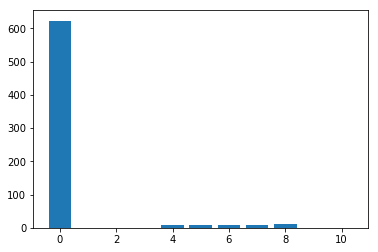

In [25]:
# plot the scores
pyplot.bar([i for i in range(len(fs.scores_))], fs.scores_)
pyplot.show()

In [9]:
# feature selection
def select_features2(x_train, y_train, x_test):
    fs2 = SelectKBest(score_func=mutual_info_classif, k=6)
    fs2.fit(x_train, y_train)
    x_train_fs2 = fs2.transform(x_train)
    x_test_fs2 = fs2.transform(x_test)
    return x_train_fs2, x_test_fs2, fs2

In [10]:
x_train_fs2, x_test_fs2, fs2 = select_features2(x_train, y_train, x_test)

In [32]:
# what are scores for the features
for i in range(len(fs2.scores_)):
    print('Feature %d: %f' % (i, fs2.scores_[i]))

Feature 0: 0.010752
Feature 1: 0.007353
Feature 2: 0.000000
Feature 3: 0.000196
Feature 4: 0.006836
Feature 5: 0.003373
Feature 6: 0.000000
Feature 7: 0.018432
Feature 8: 0.000000
Feature 9: 0.007171
Feature 10: 0.000000


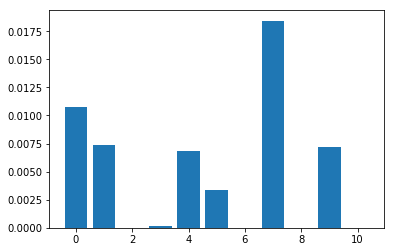

In [33]:
# plot the scores
pyplot.bar([i for i in range(len(fs2.scores_))], fs2.scores_)
pyplot.show()

In [11]:
# fit the model
model = LogisticRegression(solver='lbfgs')
model.fit(x_train, y_train)
# evaluate the model
yhat = model.predict(x_test)
# evaluate predictions
accuracy = accuracy_score(y_test, yhat)
print('Accuracy: %.2f' % (accuracy*100))

Accuracy: 61.03


In [12]:
# fit the model
model = LogisticRegression(solver='lbfgs')
model.fit(x_train_fs, y_train)
# evaluate the model
yhat = model.predict(x_test_fs)
# evaluate predictions
accuracy = accuracy_score(y_test, yhat)
print('Accuracy: %.2f' % (accuracy*100))

Accuracy: 57.93


In [13]:
# fit the model
model = LogisticRegression(solver='lbfgs')
model.fit(x_train_fs2, y_train)
# evaluate the model
yhat = model.predict(x_test_fs2)
# evaluate predictions
accuracy = accuracy_score(y_test, yhat)
print('Accuracy: %.2f' % (accuracy*100))

Accuracy: 60.66


# Logistic Regression

## Sin la columna Text

In [15]:
log_reg_grid_param = {'solver': ['liblinear'],
               'penalty': ['l1', 'l2'],
                "C": np.logspace(-4, 4, 20)}
# tuned hpyerparameters :(best parameters)  {'C': 0.012742749857031334, 'penalty': 'l2', 'solver': 'liblinear'}
# accuracy : 0.5238363753376147


#log_reg_grid_param = {'solver': ['liblinear', 'lbfgs', 'newton-cg'],
#                "C": np.logspace(-4, 4, 20)}
# tuned hpyerparameters :(best parameters)  {'C': 206.913808111479, 'solver': 'liblinear'}
# accuracy : 0.6762867722923174

#log_reg_grid_param = {'penalty': ['l1', 'l2'],
#                "C": np.logspace(-4, 4, 20)}
# tuned hpyerparameters :(best parameters)  {'C': 11.288378916846883, 'penalty': 'l1'}
# accuracy : 0.6773280120566767

In [16]:
logisticReggesion = LogisticRegression()

In [17]:
logistic_GS = GridSearchCV(estimator=logisticReggesion, param_grid=log_reg_grid_param, verbose=1, scoring="f1", cv=5, n_jobs=-1)
logistic_GS.fit(x_train, y_train)
print("tuned hpyerparameters :(best parameters) ",logistic_GS.best_params_)
print("accuracy :",logistic_GS.best_score_)

Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.6s


tuned hpyerparameters :(best parameters)  {'C': 0.012742749857031334, 'penalty': 'l2', 'solver': 'liblinear'}
accuracy : 0.5238363753376147


[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    3.5s finished


## Con la columna Text

In [18]:
log_reg_grid_param2 = {'solver': ['liblinear'],
               'penalty': ['l1', 'l2'],
                "C": np.logspace(-4, 4, 20)}
# tuned hpyerparameters :(best parameters)  {'C': 1.623776739188721, 'penalty': 'l1', 'solver': 'liblinear'}
# accuracy : 0.7345377363929668


log_reg_grid_param = {'solver': ['liblinear', 'lbfgs', 'newton-cg'],
                    "C": np.logspace(-4, 4, 20)}
# tuned hpyerparameters :(best parameters)  {'C': 0.615848211066026, 'solver': 'liblinear'}
# accuracy : 0.7332050067780481

#log_reg_grid_param = {'penalty': ['l1', 'l2'],
#                "C": np.logspace(-4, 4, 20)}
# tuned hpyerparameters :(best parameters)  {'C': 11.288378916846883, 'penalty': 'l1'}
# accuracy : 0.6773280120566767

In [19]:
logisticReggesion2 = LogisticRegression()

In [20]:
logistic_GS2 = GridSearchCV(estimator=logisticReggesion2, param_grid=log_reg_grid_param2, verbose=1, scoring="f1", cv=5, n_jobs=-1)
logistic_GS2.fit(x_train2, y_train2)
print("tuned hpyerparameters :(best parameters) ",logistic_GS2.best_params_)
print("accuracy :",logistic_GS2.best_score_)

Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    6.4s


tuned hpyerparameters :(best parameters)  {'C': 1.623776739188721, 'penalty': 'l1', 'solver': 'liblinear'}
accuracy : 0.7345377363929668


[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    6.9s finished


In [ ]:
logistic_GS2_predict = logistic_GS2.predict(data_test)

In [ ]:
kaggle_logistic_GS2_submit = {'id': kaggleId, 'target': logistic_GS2_predict}
kaggle_logistic_GS2_submit_DF = pd.DataFrame(data=kaggle_logistic_GS2_submit)

In [ ]:
kaggle_logistic_GS2_submit_DF.to_csv('setSubmitLogistic.csv', index=False)

# KNN

## Sin la columna Text

In [24]:
#knn_grid_param = {'n_neighbors': [3,5,11,19],
#               'algorithm': ['auto'],
#               'metric': ['manhattan', 'euclidean'],
#                'weights': ['uniform', 'distance']}
# tuned hpyerparameters :(best parameters)  {'algorithm': 'auto', 'metric': 'manhattan', 'n_neighbors': 19, 'weights': 'distance'}
# accuracy : 0.5584487464918637

#knn_grid_param = {'n_neighbors': [11,19,25,30],
#               'algorithm': ['auto'],
#               'metric': ['manhattan', 'euclidean'],
#                'weights': ['uniform', 'distance']}
# tuned hpyerparameters :(best parameters)  {'algorithm': 'auto', 'metric': 'manhattan', 'n_neighbors': 19, 'weights': 'distance'}
# accuracy : 0.5584487464918637

#knn_grid_param = {'n_neighbors': [14,15,16,17,18,19,20],
#               'algorithm': ['auto'],
#               'metric': ['manhattan', 'euclidean'],
#                'weights': ['uniform', 'distance']}
# tuned hpyerparameters :(best parameters)  {'algorithm': 'auto', 'metric': 'manhattan', 'n_neighbors': 17, 'weights': 'distance'}
# accuracy : 0.5602674085086873

knn_grid_param = {'n_neighbors': [3,7,15,50,100,150,200],
               'algorithm': ['auto'],
               'metric': ['manhattan', 'euclidean'],
                'weights': ['uniform', 'distance']}
# tuned hpyerparameters :(best parameters)  {'algorithm': 'auto', 'metric': 'manhattan', 'n_neighbors': 50, 'weights': 'distance'}
# accuracy : 0.5860598980781437

In [22]:
knnClassifier = KNeighborsClassifier()

In [25]:
knn_GS = GridSearchCV(estimator=knnClassifier, param_grid=knn_grid_param, verbose=1, scoring="f1", cv=5, n_jobs=-1)
knn_GS.fit(x_train, y_train)
print("tuned hpyerparameters :(best parameters) ",knn_GS.best_params_)
print("accuracy :",knn_GS.best_score_)

Fitting 5 folds for each of 28 candidates, totalling 140 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.8s


tuned hpyerparameters :(best parameters)  {'algorithm': 'auto', 'metric': 'manhattan', 'n_neighbors': 50, 'weights': 'distance'}
accuracy : 0.5860598980781437


[Parallel(n_jobs=-1)]: Done 140 out of 140 | elapsed:    3.4s finished


## Con la columna Text

In [27]:
#knn_grid_param2 = {'n_neighbors': [3,5,10,15],
#               'algorithm': ['auto'],
#               'metric': ['manhattan', 'euclidean'],
#                'weights': ['uniform', 'distance']}
# tuned hpyerparameters :(best parameters)  {'algorithm': 'auto', 'metric': 'manhattan', 'n_neighbors': 3, 'weights': 'distance'}
# accuracy : 0.5189932870856757

knn_grid_param2 = {'n_neighbors': [2,3,4,10,30,70],
               'algorithm': ['auto'],
               'metric': ['manhattan', 'euclidean'],
                'weights': ['uniform', 'distance']}
# tuned hpyerparameters :(best parameters)  {'algorithm': 'auto', 'metric': 'manhattan', 'n_neighbors': 2, 'weights': 'distance'}
# accuracy : 0.5322323330364732

#knn_grid_param = {'n_neighbors': [14,15,16,17,18,19,20],
#               'algorithm': ['auto'],
#               'metric': ['manhattan', 'euclidean'],
#                'weights': ['uniform', 'distance']}
# tuned hpyerparameters :(best parameters)  {'algorithm': 'auto', 'metric': 'manhattan', 'n_neighbors': 17, 'weights': 'distance'}
# accuracy : 0.5602674085086873

#knn_grid_param = {'n_neighbors': [17,50,100,150,200],
#               'algorithm': ['auto'],
#               'metric': ['manhattan', 'euclidean'],
#                'weights': ['uniform', 'distance']}
# tuned hpyerparameters :(best parameters)  {'algorithm': 'auto', 'metric': 'manhattan', 'n_neighbors': 17, 'weights': 'distance'}
# accuracy : 0.5602674085086873

In [28]:
knnClassifier2 = KNeighborsClassifier()

In [29]:
knn_GS2 = GridSearchCV(estimator=knnClassifier2, param_grid=knn_grid_param2, verbose=1, scoring="f1", cv=5, n_jobs=-1)
knn_GS2.fit(x_train2, y_train2)
print("tuned hpyerparameters :(best parameters) ",knn_GS2.best_params_)
print("accuracy :",knn_GS2.best_score_)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   12.1s


tuned hpyerparameters :(best parameters)  {'algorithm': 'auto', 'metric': 'manhattan', 'n_neighbors': 2, 'weights': 'distance'}
accuracy : 0.5322323330364732


[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:   31.6s finished


In [ ]:
knn_GS2_predict = knn_GS2.predict(data_test)

In [ ]:
kaggle_knn_GS2_submit = {'id': kaggleId, 'target': knn_GS2_predict}
kaggle_knn_GS2_submit_DF = pd.DataFrame(data=kaggle_knn_GS2_submit)

In [ ]:
kaggle_knn_GS2_submit_DF.to_csv('setSubmitKNN.csv', index=False)

# Decision Tree

## Sin la columna Text

In [30]:
decision_tree_grid = {'max_depth': [20,40,60,80,100],
                     'min_samples_split': [2,4,6,8,10],
                     'min_samples_leaf': [1,2,5,10]}
# tuned hpyerparameters :(best parameters)  {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2}
# accuracy : 0.5658834497487223

In [31]:
decisionClassifier = DecisionTreeClassifier()

In [32]:
decision_GS = GridSearchCV(estimator=decisionClassifier, param_grid=decision_tree_grid, scoring='f1', verbose=1, cv=5, n_jobs=-1)
decision_GS.fit(x_train, y_train)
print("tuned hpyerparameters :(best parameters) ",decision_GS.best_params_)
print("accuracy :",decision_GS.best_score_)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.5s


tuned hpyerparameters :(best parameters)  {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2}
accuracy : 0.5658834497487223


[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    3.1s finished


## Con la columna Text

In [33]:
#decision_tree_grid2 = {'max_depth': [20,40,60,80,100],
#                     'min_samples_split': [2,4,6,8,10],
#                     'min_samples_leaf': [1,2,5,10]}
# tuned hpyerparameters :(best parameters)  {'max_depth': 100, 'min_samples_leaf': 1, 'min_samples_split': 10}
# accuracy : 0.6500121884229279

#decision_tree_grid2 = {'max_depth': [90,100,150,200],
#                     'min_samples_split': [8,10,12,15],
#                     'min_samples_leaf': [1,2,3]}
# tuned hpyerparameters :(best parameters)  {'max_depth': 150, 'min_samples_leaf': 1, 'min_samples_split': 10}
# accuracy : 0.6560101863933094

decision_tree_grid2 = {'max_depth': [140,150,160],
                     'min_samples_split': [8,9,10,11],
                     'min_samples_leaf': [1,2,3]}
# tuned hpyerparameters :(best parameters)  {'max_depth': 140, 'min_samples_leaf': 1, 'min_samples_split': 10}
# accuracy : 0.6652465246582776

In [34]:
decisionClassifier2 = DecisionTreeClassifier()

In [35]:
decision_GS2 = GridSearchCV(estimator=decisionClassifier2, param_grid=decision_tree_grid2, scoring='f1', verbose=1, cv=5, n_jobs=-1)
decision_GS2.fit(x_train2, y_train2)
print("tuned hpyerparameters :(best parameters) ",decision_GS2.best_params_)
print("accuracy :",decision_GS2.best_score_)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    6.9s
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:   26.2s finished


tuned hpyerparameters :(best parameters)  {'max_depth': 140, 'min_samples_leaf': 1, 'min_samples_split': 10}
accuracy : 0.6652465246582776


In [ ]:
decision_GS2_predict = decision_GS2.predict(data_test)

In [ ]:
kaggle_decision_GS2_submit = {'id': kaggleId, 'target': decision_GS2_predict}
kaggle_decision_GS2_submit_DF = pd.DataFrame(data=kaggle_decision_GS2_submit)

In [ ]:
kaggle_decision_GS2_submit_DF.to_csv('setSubmitDecision.csv', index=False)

# Random Forest

## Sin la columna Text

In [ ]:
#random_forest_grid_param = {'bootstrap': [True, False],
#                            'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
#                            'max_features': ['auto', 'sqrt'],
#                            'min_samples_leaf': [1, 2, 4],
#                            'min_samples_split': [2, 5, 10],
#                            'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}

#random_forest_grid_param = {'bootstrap': [True, False],
#                            'max_depth': [10, 20, 30, None],
#                            'max_features': ['auto', 'sqrt'],
#                            'min_samples_leaf': [1, 2, 4],
#                            'min_samples_split': [2, 5, 10],
#                            'n_estimators': [200, 400, 600]}
#tuned hpyerparameters :(best parameters)  {'bootstrap': True, 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 200}
#accuracy : 0.653347094748209

#random_forest_grid_param = {'bootstrap': [True],
#                            'max_depth': [2, 4, 6, None],
#                            'max_features': ['sqrt'],
#                            'min_samples_leaf': [1, 5, 7],
#                            'min_samples_split': [9, 10, 11],
#                            'n_estimators': [50,100,200]}
#tuned hpyerparameters :(best parameters)  {'bootstrap': True, 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 50}
#accuracy : 0.6534201199529246

random_forest_grid_param = {'bootstrap': [True],
                            'max_depth': [2, 4, 6, None],
                            'max_features': ['sqrt'],
                            'min_samples_leaf': [1,10,15],
                            'min_samples_split': [9, 10, 11],
                            'n_estimators': [20,30,50,75]}
#tuned hpyerparameters :(best parameters)  {'bootstrap': True, 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 9, 'n_estimators': 20}
#accuracy : 0.6541641584525214

#random_forest_grid_param = {'bootstrap': [True],
#                            'max_depth': [50, 60, 70, None],
#                            'max_features': ['sqrt'],
#                            'min_samples_leaf': [1,2,3],
#                            'min_samples_split': [9, 10, 11],
#                            'n_estimators': [5,9,12,15,20]}
#tuned hpyerparameters :(best parameters)  {'bootstrap': True, 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 11, 'n_estimators': 15}
#accuracy : 0.6492213934204937

In [ ]:
rfClassifier = RandomForestClassifier()

In [ ]:
rf_GS = GridSearchCV(estimator=rfClassifier, param_grid=random_forest_grid_param, scoring='f1', verbose=1, cv=5, n_jobs=-1)
rf_GS.fit(x_train, y_train)
print("tuned hpyerparameters :(best parameters) ",rf_GS.best_params_)
print("accuracy :",rf_GS.best_score_)

## Con la columna Text

In [ ]:
#random_forest_grid_param2 = {'bootstrap': [True, False],
#                            'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
#                            'max_features': ['auto', 'sqrt'],
#                            'min_samples_leaf': [1, 2, 4],
#                            'min_samples_split': [2, 5, 10],
#                            'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}

#random_forest_grid_param2 = {'bootstrap': [True, False],
#                            'max_depth': [10, 20, 30, None],
#                            'max_features': ['auto', 'sqrt'],
#                            'min_samples_leaf': [1, 2, 4],
#                            'min_samples_split': [2, 5, 10],
#                            'n_estimators': [200, 400, 600]}
#tuned hpyerparameters :(best parameters)  {'bootstrap': True, 'max_depth': None, 'max_features': 'sqrt', 
# 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 200}
#accuracy : 0.7212366222022716

random_forest_grid_param2 = {'bootstrap': [True],
                            'max_depth': [None],
                            'max_features': ['sqrt'],
                            'min_samples_leaf': [1,2,10],
                            'min_samples_split': [10,12,15],
                            'n_estimators': [50,100,200]}
#tuned hpyerparameters :(best parameters)  {'bootstrap': True, 'max_depth': None, 'max_features': 'sqrt', 
#'min_samples_leaf': 1, 'min_samples_split': 12, 'n_estimators': 100}
#accuracy : 0.7214048228595785

In [ ]:
rfClassifier2 = RandomForestClassifier()

In [ ]:
rf_GS2 = GridSearchCV(estimator=rfClassifier2, param_grid=random_forest_grid_param2, scoring='f1', verbose=1, cv=5, n_jobs=-1)
rf_GS2.fit(x_train2, y_train2)
print("tuned hpyerparameters :(best parameters) ",rf_GS2.best_params_)
print("accuracy :",rf_GS2.best_score_)

In [ ]:
rf_GS2_predict = rf_GS2.predict(data_test)

In [ ]:
kaggle_rf_GS2_submit = {'id': kaggleId, 'target': rf_GS2_predict}
kaggle_rf_GS2_submit_DF = pd.DataFrame(data=kaggle_rf_GS2_submit)

In [ ]:
kaggle_rf_GS2_submit_DF.to_csv('setSubmitRF.csv', index=False)

# Ada Boost

## Sin la columna Text

In [36]:
ada_grid = {'n_estimators': np.arange(280,400,10),
            'learning_rate' : [0.01,0.05,0.1,0.3,0.7,1]}
#tuned hpyerparameters :(best parameters)  {'learning_rate': 0.7, 'n_estimators': 320}
#accuracy : 0.5448198513892962

In [37]:
ada = AdaBoostClassifier()

In [38]:
ada_GS = GridSearchCV(estimator=ada, param_grid=ada_grid, scoring='f1', verbose=1, cv=5, n_jobs=-1)
ada_GS.fit(x_train, y_train)
print("tuned hpyerparameters :(best parameters) ",ada_GS.best_params_)
print("accuracy :",ada_GS.best_score_)

Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   10.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   46.8s
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:  1.5min finished


tuned hpyerparameters :(best parameters)  {'learning_rate': 0.7, 'n_estimators': 320}
accuracy : 0.5448198513892962


## Con la columna Text

In [43]:
ada_grid2 = {'n_estimators': np.arange(280,400,10),
            'learning_rate' : [0.01,0.1,1]}
#tuned hpyerparameters :(best parameters)  {'learning_rate': 1, 'n_estimators': 380}
#accuracy : 0.7211916742238501

In [41]:
ada2 = AdaBoostClassifier()

In [44]:
ada_GS2 = GridSearchCV(estimator=ada2, param_grid=ada_grid2, scoring='f1', verbose=1, cv=5, n_jobs=-1)
ada_GS2.fit(x_train2, y_train2)
print("tuned hpyerparameters :(best parameters) ",ada_GS2.best_params_)
print("accuracy :",ada_GS2.best_score_)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:  7.9min finished


tuned hpyerparameters :(best parameters)  {'learning_rate': 1, 'n_estimators': 380}
accuracy : 0.7211916742238501


In [ ]:
ada_GS2_predict = ada_GS2.predict(data_test)

In [ ]:
kaggle_ada_GS2_submit = {'id': kaggleId, 'target': ada_GS2_predict}
kaggle_ada_GS2_submit_DF = pd.DataFrame(data=kaggle_ada_GS2_submit)

In [ ]:
kaggle_ada_GS2_submit_DF.to_csv('setSubmitAda.csv', index=False)

# XGBoost

## Sin la columna Text

In [ ]:
#xgb_grid_param = {
#    'max_depth': [5,7,9],
#    'gamma': [0.5, 1, 1.5],
#    'subsample': [0.4,0.5,0.6], #[0.4,0.5,0.6,0.7,0.8,0.9,1.0],
#    'min_child_weight': [1,3,4],
#    'colsample_bytree': [0.5,0.6,0.7], #[0.5,0.6,0.7,0.8],
#    'n_estimators': [100, 200], #[1000,2000,3000]
#    'learning_rate': [0.1, 1]}
#tuned hpyerparameters :(best parameters)  {'colsample_bytree': 0.7, 'gamma': 1, 'learning_rate': 0.1, 
#    'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.5}
#accuracy : 0.670547740462945

#xgb_grid_param = {
#    'max_depth': [9,12],
#    'gamma': [0.9,1,1.2],
#    'subsample': [0.5,0.8], #[0.4,0.5,0.6,0.7,0.8,0.9,1.0],
#    'min_child_weight': [1,3,4],
#    'colsample_bytree': [0.7,0.9], #[0.5,0.6,0.7,0.8],
#    'n_estimators': [200,350], #[1000,2000,3000]
#    'learning_rate': [0.1, 0.5]}
#tuned hpyerparameters :(best parameters)  {'colsample_bytree': 0.9, 'gamma': 1.2, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 350, 'subsample': 0.8}
#accuracy : 0.6696604992524797

xgb_grid_param = {
    'max_depth': [9],
    'gamma': [1,1.2],
    'subsample': [0.8,1], #[0.4,0.5,0.6,0.7,0.8,0.9,1.0],
    'min_child_weight': [1,2],
    'colsample_bytree': [0.7,0.9], #[0.5,0.6,0.7,0.8],
    'n_estimators': [600], #[1000,2000,3000]
    'learning_rate': [0.1]}
#tuned hpyerparameters :(best parameters)  {'colsample_bytree': 0.9, 'gamma': 1.2, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 600, 'subsample': 0.8}
#accuracy : 0.6681432627951468

In [ ]:
xgboost = XGBClassifier()

In [ ]:
xgboost_GS = GridSearchCV(estimator=xgboost, param_grid=xgb_grid_param, scoring='f1', verbose=1, cv=5, n_jobs=-1)
xgboost_GS.fit(x_train, y_train)
print("tuned hpyerparameters :(best parameters) ",xgboost_GS.best_params_)
print("accuracy :",xgboost_GS.best_score_)

## Con la columna Text

In [25]:
#xgb_grid_param2 = {
#    'max_depth': [2,3,5,6,10],
#    'gamma': [1],
#    'subsample': [0.5], #[0.4,0.5,0.6,0.7,0.8,0.9,1.0],
#    'min_child_weight': [1,2],
#    'colsample_bytree': [0.7], #[0.5,0.6,0.7,0.8],
#    'n_estimators': [300], #[1000,2000,3000]
#    'learning_rate': [1]}
#tuned hpyerparameters :(best parameters)  {'colsample_bytree': 0.7, 'gamma': 1, 'learning_rate': 1, 
#'max_depth': 3, 'min_child_weight': 2, 'n_estimators': 300, 'subsample': 0.5}
#accuracy : 0.6953201310248737

#xgb_grid_param2 = {
#    'max_depth': [3,4],
#    'gamma': [0.7,0.8],
#    'subsample': [0.5], #[0.4,0.5,0.6,0.7,0.8,0.9,1.0],
#    'min_child_weight': [1],
#    'colsample_bytree': [0.7], #[0.5,0.6,0.7,0.8],
#    'n_estimators': [300], #[1000,2000,3000]
#    'learning_rate': [1]}
#tuned hpyerparameters :(best parameters)  {'colsample_bytree': 0.7, 'gamma': 0.8, 'learning_rate': 1, '
#max_depth': 3, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 0.5}
#accuracy : 0.6964528252886683

#xgb_grid_param2 = {
#    'max_depth': [3],
#    'gamma': [0.8],
#    'subsample': [0.7], #[0.4,0.5,0.6,0.7,0.8,0.9,1.0],
#    'min_child_weight': [1,2],
#    'colsample_bytree': [0.6,0.7,0.8], #[0.5,0.6,0.7,0.8],
#    'n_estimators': [300], #[1000,2000,3000]
#    'learning_rate': [1]}
#tuned hpyerparameters :(best parameters)  {'colsample_bytree': 0.8, 'gamma': 0.8, 'learning_rate': 1, 
#'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 0.7}
#accuracy : 0.7115072057243385

xgb_grid_param2 = {
    'max_depth': [3],
    'gamma': [0.8],
    'subsample': [0.7], #[0.4,0.5,0.6,0.7,0.8,0.9,1.0],
    'min_child_weight': [1],
    'colsample_bytree': [0.8], #[0.5,0.6,0.7,0.8],
    'n_estimators': [200,300,400], #[1000,2000,3000]
    'learning_rate': [0.1,1]}
#tuned hpyerparameters :(best parameters)  {'colsample_bytree': 0.8, 'gamma': 0.8, 'learning_rate': 1, 
#'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.7}
#accuracy : 0.712881419602948

In [29]:
xgboost2 = XGBClassifier()

In [30]:
xgboost_GS2 = GridSearchCV(estimator=xgboost2, param_grid=xgb_grid_param2, scoring='f1', verbose=1, cv=5, n_jobs=-1)
xgboost_GS2.fit(x_train2, y_train2)
print("tuned hpyerparameters :(best parameters) ",xgboost_GS2.best_params_)
print("accuracy :",xgboost_GS2.best_score_)

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [ ]:
xgboost_GS2_predict = xgboost_GS2.predict(data_test)

In [ ]:
kaggle_xgboost_GS2_submit = {'id': kaggleId, 'target': xgboost_GS2_predict}
kaggle_xgboost_GS2_submit_DF = pd.DataFrame(data=kaggle_xgboost_GS2_submit)

In [ ]:
kaggle_xgboost_GS2_submit_DF.to_csv('setSubmitXgboost.csv', index=False)

# Light GBM

## Sin la columna Text

In [ ]:
#gbm_param = {'n_estimators': [100, 400],
#               'max_depth':  [-1, 4, 10],
#               'num_leaves': [15, 31, 63, 127],
#               'subsample': [0.6, 0.7, 0.8],
#               'colsample_bytree': [0.6, 0.7, 0.8]}
#tuned hpyerparameters :(best parameters)  {'colsample_bytree': 0.6, 'max_depth': 10, 'n_estimators': 400, 
#'num_leaves': 15, 'subsample': 0.6}
#accuracy : 0.6008785161044997

#gbm_param = {'n_estimators': [400, 600, 1000],
#               'max_depth':  [-1, 10, 30],
#               'num_leaves': [3,6,9,12,15],
#               'subsample': [0.5,0.6, 0.7],
#               'colsample_bytree': [0.5,0.6, 0.7]}
#tuned hpyerparameters :(best parameters)  {'colsample_bytree': 0.6, 'max_depth': -1, 'n_estimators': 1000, 'num_leaves': 15, 'subsample': 0.5}
#accuracy : 0.6040637466465371

gbm_param = {'n_estimators': [1000,1500,2000],
               'max_depth':  [-1, 10, 30, 50],
               'num_leaves': [9,12,15,17,20],
               'subsample': [0.3,0.4,0.5,0.6],
               'colsample_bytree': [0.5,0.6, 0.7]}
#tuned hpyerparameters :(best parameters)  {'colsample_bytree': 0.6, 'max_depth': -1, 'n_estimators': 1000, 'num_leaves': 15, 'subsample': 0.3}
#accuracy : 0.6040637466465371

In [ ]:
gbm = LGBMClassifier()

In [ ]:
gbm_GS = GridSearchCV(estimator=gbm, param_grid=gbm_param, scoring='f1', verbose=1, cv=5, n_jobs=-1)
gbm_GS.fit(x_train, y_train)
print("tuned hpyerparameters :(best parameters) ",gbm_GS.best_params_)
print("accuracy :",gbm_GS.best_score_)

## Con la columna Text

In [ ]:
#gbm_param2 = {'n_estimators': [100, 200],
#               'max_depth':  [-1, 4, 10],
#               'num_leaves': [15, 31, 63, 127],
#               'subsample': [0.6, 0.7, 0.8],
#               'colsample_bytree': [0.6, 0.7, 0.8]}
#tuned hpyerparameters :(best parameters)  {'colsample_bytree': 0.7, 'max_depth': -1, 'n_estimators': 100, 
#'num_leaves': 63, 'subsample': 0.6}
#accuracy : 0.6962262268218196

gbm_param2 = {'n_estimators': [50,75,100],
               'max_depth':  [-1,2,3],
               'num_leaves': [50,60,70],
               'subsample': [0.5,0.6,0.7],
               'colsample_bytree': [0.6,0.7,0.8]}
#tuned hpyerparameters :(best parameters)  {'colsample_bytree': 0.8, 'max_depth': -1, 'n_estimators': 75, 
#'num_leaves': 70, 'subsample': 0.5}
#accuracy : 0.6953875796154907

#gbm_param = {'n_estimators': [1000,1500,2000],
#               'max_depth':  [-1, 10, 30, 50],
#               'num_leaves': [9,12,15,17,20],
#               'subsample': [0.3,0.4,0.5,0.6],
#               'colsample_bytree': [0.5,0.6, 0.7]}
#tuned hpyerparameters :(best parameters)  {'colsample_bytree': 0.6, 'max_depth': -1, 'n_estimators': 1000, 'num_leaves': 15, 'subsample': 0.3}
#accuracy : 0.6040637466465371

In [ ]:
gbm2 = LGBMClassifier()

In [ ]:
gbm_GS2 = GridSearchCV(estimator=gbm2, param_grid=gbm_param2, scoring='f1', verbose=1, cv=5, n_jobs=-1)
gbm_GS2.fit(x_train2, y_train2)
print("tuned hpyerparameters :(best parameters) ",gbm_GS2.best_params_)
print("accuracy :",gbm_GS2.best_score_)

In [ ]:
gbm_GS2_predict = gbm_GS2.predict(data_test)

In [ ]:
kaggle_gbm_GS2_submit = {'id': kaggleId, 'target': gbm_GS2_predict}
kaggle_gbm_GS2_submit_DF = pd.DataFrame(data=kaggle_gbm_GS2_submit)

In [ ]:
kaggle_gbm_GS2_submit_DF.to_csv('setSubmitGBM.csv', index=False)